In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from scipy import stats

import pickle
import joblib
import io

import warnings
warnings.filterwarnings('ignore')

import os
from project_lib import Project
project = Project()
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

# Display option
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress= True)

In [2]:
def clean_data(df, list_col, label):
    clean = df.drop(columns = list_col)
    X = clean.drop(columns = label)
    y = clean[label]
    return X, y

# Train_test_valid_split
def split_data(df, label):
    df_train, df_rem = train_test_split(df, test_size=0.3, random_state=579, stratify=df[label], shuffle=True)
    df_valid, df_test = train_test_split(df_rem, train_size=0.3333, random_state=579, stratify=df_rem[label], shuffle=True)
    return df_train, df_valid, df_test

def train_model(X_train, y_train, X_val, y_val):
    model = XGBClassifier()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=10, eval_metric='auc', verbose=10)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print ('AUC: ', np.round(roc_auc_score(y_test, y_pred_proba), 2))
    print ('Precision: ', np.round(precision_score(y_test, y_pred), 2))
    print ('Recall: ', np.round(recall_score(y_test, y_pred), 2))
    print ('F1: ', np.round(f1_score(y_test, y_pred), 2))

def plot_roc_curve(true_y, y_preds):
    fpr, tpr, thresholds = roc_curve(true_y, y_preds)
    auc = roc_auc_score(true_y, y_preds)
    plt.plot(fpr, tpr, label='AUC = '+str(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

def conf_matrix(y_true, y_pred, model):
    conf_matrx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    ax.matshow(conf_matrx, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrx.shape[0]):
        for j in range(conf_matrx.shape[1]):
            ax.text(x=j, y=i, s=conf_matrx[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title(model)

In [3]:
buffer = wslib.load_data('df_feature_old.pkl')
df_feature = pickle.load(buffer)
df_feature.label = df_feature.label.astype(int)

In [4]:
df_train, df_valid, df_test = split_data(df_feature, 'label')

In [5]:
# Split X, y
list_col = ['cif_number', 'obs_date']
X_train, y_train = clean_data(df_train, list_col, 'label')
X_valid, y_valid = clean_data(df_valid, list_col, 'label')
X_test, y_test = clean_data(df_test, list_col, 'label')

In [6]:
model = train_model(X_train, y_train, X_valid, y_valid)
print ('Evaluate model:')
evaluate_model(model, X_test, y_test)

[0]	validation_0-auc:0.84348	validation_1-auc:0.82976
[10]	validation_0-auc:0.88041	validation_1-auc:0.86114
[20]	validation_0-auc:0.90128	validation_1-auc:0.86963
[30]	validation_0-auc:0.91330	validation_1-auc:0.87153
[40]	validation_0-auc:0.92242	validation_1-auc:0.87134
[43]	validation_0-auc:0.92476	validation_1-auc:0.87147
Evaluate model:
AUC:  0.88
Precision:  0.93
Recall:  0.43
F1:  0.59


In [15]:
X_pred_proba = model.predict_proba(X_test)[::,1]
X_pred = model.predict(X_test).astype(int)

In [21]:
result_customer = pd.DataFrame({'cif': df_test.cif_number, 'label': X_pred, 'score': X_pred_proba, 'obs_date': df_test.obs_date})
result_customer

,cif,label,score,obs_date
144184,00654919,0,0.09,2022-06-28
127373,03198534,0,0.01,2022-05-16
4854,03730029,0,0.09,2022-05-16
41524,01837363,0,0.09,2022-04-10
124059,03276973,0,0.00,2022-05-16
...,...,...,...,...
35137,01107922,0,0.01,2022-04-10
91515,00287306,0,0.01,2022-05-16
94374,66299844,0,0.01,2022-05-16
137927,03861229,0,0.06,2022-05-16


In [81]:
result_customer[result_customer.label==1].shape

(1753, 4)

In [80]:
result_customer[result_customer.label==1].groupby(['obs_date'], as_index=False)['cif'].count()

,obs_date,cif
0,2022-02-18,4
1,2022-04-10,13
2,2022-04-30,34
3,2022-05-16,39
4,2022-06-28,50
5,2022-08-30,1613


In [37]:
l = result_customer[result_customer.label==1].merge(df_test, left_on=['cif', 'obs_date'], right_on=['cif_number','obs_date'], how='left')

In [64]:
l.columns

Index(['cif', 'label_x', 'score', 'obs_date', 'cif_number', 'label_y',
       'EB_NUM_TRANS_OUT_28', 'EB_SUM_TRANS_AMT_OUT_28',
       'EB_AVG_TRANS_AMT_OUT_28', 'EB_STD_TRANS_AMT_OUT_28',
       'EB_MIN_TRANS_AMT_OUT_28', 'EB_MAX_TRANS_AMT_OUT_28',
       'EB_NUM_TRANS_OUT_56', 'EB_SUM_TRANS_AMT_OUT_56',
       'EB_AVG_TRANS_AMT_OUT_56', 'EB_STD_TRANS_AMT_OUT_56',
       'EB_MIN_TRANS_AMT_OUT_56', 'EB_MAX_TRANS_AMT_OUT_56',
       'EB_NUM_TRANS_OUT_84', 'EB_SUM_TRANS_AMT_OUT_84',
       'EB_AVG_TRANS_AMT_OUT_84', 'EB_STD_TRANS_AMT_OUT_84',
       'EB_MIN_TRANS_AMT_OUT_84', 'EB_MAX_TRANS_AMT_OUT_84',
       'CASA_ACC_SUM_TRANS_AMT_OUT_28', 'CASA_ACC_NUM_TRANS_AMT_OUT_28',
       'CASA_ACC_AVG_TRANS_AMT_OUT_28', 'CASA_ACC_STD_TRANS_AMT_OUT_28',
       'CASA_ACC_MIN_TRANS_AMT_OUT_28', 'CASA_ACC_MAX_TRANS_AMT_OUT_28',
       'CASA_ACC_SUM_TRANS_AMT_OUT_56', 'CASA_ACC_NUM_TRANS_AMT_OUT_56',
       'CASA_ACC_AVG_TRANS_AMT_OUT_56', 'CASA_ACC_STD_TRANS_AMT_OUT_56',
       'CASA_ACC_MIN_TRANS_

In [74]:
l1 = l[['cif',
'obs_date',
'CASA_ACC_NUM_TRANS_AMT_OUT_28']]

In [75]:
obs_date = list(l1['obs_date'].unique())

In [67]:
obs_date

['2022-06-28',
 '2022-08-30',
 '2022-04-30',
 '2022-05-16',
 '2022-04-10',
 '2022-02-18']

In [76]:
dict1 = {}
for d in obs_date:
    p1 = l1[l1['obs_date']==d]
#     print(p1)
    q1 = p1['CASA_ACC_NUM_TRANS_AMT_OUT_28'].quantile(np.linspace(.1,1,9,0))
    q1['Date'] = d
    dict1[d] = q1
dict1.keys()

dict_keys(['2022-06-28', '2022-08-30', '2022-04-30', '2022-05-16', '2022-04-10', '2022-02-18'])

In [77]:
per1 = pd.DataFrame()
p1 = pd.DataFrame()
for key in dict1.keys():
    p1 = dict1[key]
    per1 = per1.append(p1)
per1

,0.1,0.2,0.30000000000000004,0.4,0.5,0.6,0.7000000000000001,0.8,0.9,Date
CASA_ACC_NUM_TRANS_AMT_OUT_28,6.40,12.40,20.50,34.00,42.00,56.20,65.70,83.60,162.30,2022-06-28
CASA_ACC_NUM_TRANS_AMT_OUT_28,7.00,12.00,16.80,21.00,26.00,31.00,37.00,46.80,64.00,2022-08-30
CASA_ACC_NUM_TRANS_AMT_OUT_28,5.00,7.00,10.20,17.80,22.00,25.60,34.20,43.00,102.20,2022-04-30
CASA_ACC_NUM_TRANS_AMT_OUT_28,13.20,16.60,28.00,35.20,44.00,69.00,82.60,107.20,180.00,2022-05-16
CASA_ACC_NUM_TRANS_AMT_OUT_28,10.00,12.80,18.20,26.20,34.00,42.20,47.40,77.40,156.20,2022-04-10
CASA_ACC_NUM_TRANS_AMT_OUT_28,40.40,42.80,45.20,47.40,49.50,51.60,55.90,64.60,73.30,2022-02-18


In [59]:
per1.reset_index()

,index,0.1,0.2,0.30000000000000004,0.4,0.5,0.6,0.7000000000000001,0.8,0.9,Date
0,EB_AVG_TRANS_AMT_OUT_28,438164.80,514466.60,679210.30,861371.40,1210981.50,1666884.80,1940317.70,2268123.60,4070477.90,2022-06-28
1,EB_AVG_TRANS_AMT_OUT_28,391316.10,631400.00,849497.60,1114463.80,1423170.50,1807554.20,2418697.30,3578266.20,5710292.30,2022-08-30
2,EB_AVG_TRANS_AMT_OUT_28,598495.60,641497.60,811632.50,1307523.60,1769920.50,2571914.00,3672696.10,4879156.80,8654691.80,2022-04-30
3,EB_AVG_TRANS_AMT_OUT_28,272686.60,517275.80,807269.80,1035936.80,1419838.00,2013994.20,2884768.40,3554608.20,4978282.00,2022-05-16
4,EB_AVG_TRANS_AMT_OUT_28,1096538.80,1324370.40,1713430.80,2044609.60,4614651.00,6162288.40,6411697.20,11286016.80,22275240.00,2022-04-10
5,EB_AVG_TRANS_AMT_OUT_28,1627529.30,1889258.60,2150987.90,3500530.40,5393979.50,7287428.60,9378350.80,11864219.20,14350087.60,2022-02-18


In [50]:
per1.T

,EB_SUM_TRANS_AMT_OUT_28,EB_SUM_TRANS_AMT_OUT_28,EB_SUM_TRANS_AMT_OUT_28,EB_SUM_TRANS_AMT_OUT_28,EB_SUM_TRANS_AMT_OUT_28,EB_SUM_TRANS_AMT_OUT_28
0.1,4004100.00,3629600.00,4318400.00,3268365.20,16161886.60,55140503.20
0.2,5973800.00,7839800.00,6237839.20,14439528.40,31561064.20,103452006.40
0.30000000000000004,14614279.20,12631521.40,10028800.00,27110000.00,69981324.40,151763509.60
0.4,19437200.00,18055824.80,15887233.60,33857046.40,97667747.20,200981759.00
0.5,27313589.00,25895619.50,26079489.00,39950000.00,112499538.00,250653381.50
0.6,40360815.20,36158542.40,39887420.00,59058268.00,206448704.80,300325004.00
0.7000000000000001,68505400.00,51920300.00,54657360.60,100260199.60,239497514.00,377540877.10
0.8,93484840.40,80446850.00,98030552.60,185003200.00,286360210.40,509845251.40
0.9,190538054.70,153350082.40,590755563.60,385624966.60,312170044.40,642149625.70
Date,2022-06-28,2022-08-30,2022-04-30,2022-05-16,2022-04-10,2022-02-18


In [8]:
a = pd.DataFrame({'feature':X_train.columns, 'importance_score':model.feature_importances_})

In [9]:
a.sort_values(by=['importance_score'], ascending=False)

,feature,importance_score
46,CASA_ACC_MIN_TRANS_AMT_IN_56,0.16
52,CASA_ACC_MIN_TRANS_AMT_IN_84,0.12
31,CASA_ACC_NUM_TRANS_AMT_OUT_84,0.05
40,CASA_ACC_MIN_TRANS_AMT_IN_28,0.04
25,CASA_ACC_NUM_TRANS_AMT_OUT_56,0.03
49,CASA_ACC_NUM_TRANS_AMT_IN_84,0.02
12,EB_NUM_TRANS_OUT_84,0.02
33,CASA_ACC_STD_TRANS_AMT_OUT_84,0.02
50,CASA_ACC_AVG_TRANS_AMT_IN_84,0.02
22,CASA_ACC_MIN_TRANS_AMT_OUT_28,0.02


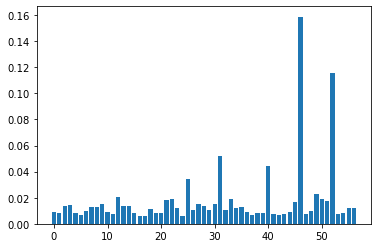

In [10]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

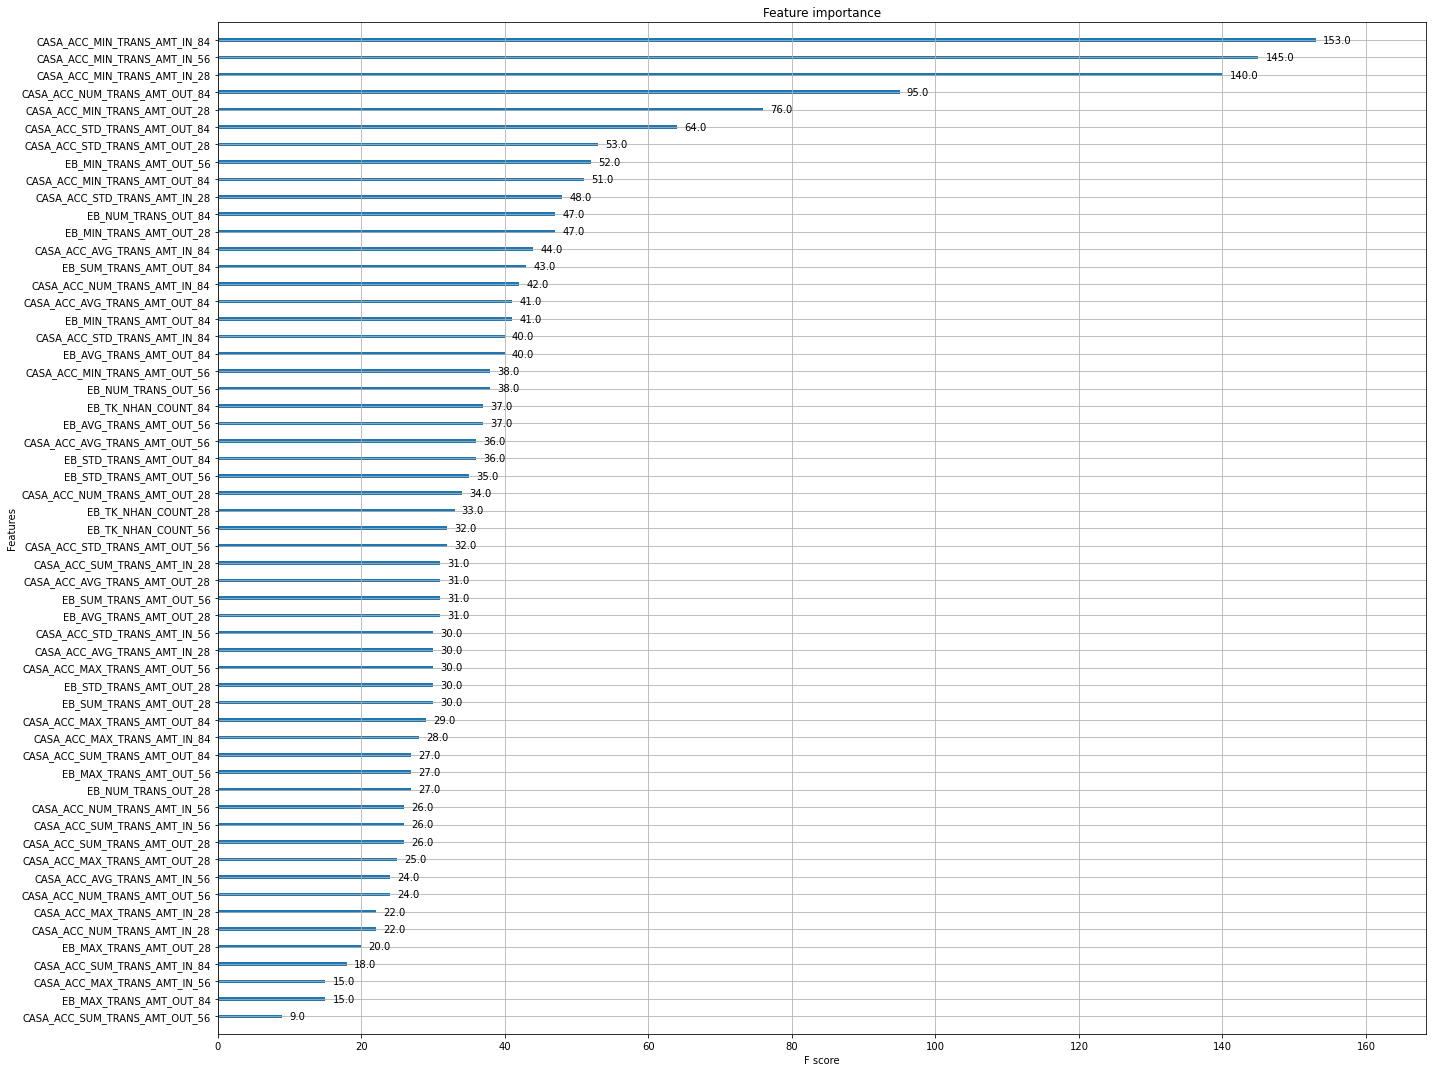

In [11]:
plt.rcParams['figure.figsize'] = [20,15]
plt.rcParams['figure.autolayout'] = True
plot_importance(model)
plt.show()